Since our data is time series, we must:
    1. Perform 31-day sliding window min-max scaling
    2. Create a 0-1 binary predictor variables on whether the coin was pumped
For __OHLCV__ Data

In [84]:
import os, sys
import pandas as pd 
import numpy as np
import requests 
from datetime import datetime, date, time, timedelta
import pytz
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
from mpl_finance import candlestick_ohlc
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.ticker as mticker
import pickle
pd.set_option('display.max_columns', 200)
%load_ext autoreload
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [85]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [86]:
print(os.getcwd())

/Users/hn/Documents/USC Others/ISI Research/PumpCoin/CrytoCompare/All_Pump_Analysis/Before_Announcement_Analysis


# Part I. Append log windows normalization

# HOURLY

In [87]:
d = pd.read_pickle('ohlcv_data_training_h.pkl').reset_index(drop=True)

In [88]:
print("Original OHLCV Data has shape: ", d.shape)

Original OHLCV Data has shape:  (43506, 302)


In [89]:
cd = pd.read_pickle("ohlcv_dict_h.pkl")

## Append Log Return Data

We append some extraneous data of the forms:
* log_return_h := closing price of hour - opening price of hour h
* log_delta_h := high price of hour - closing price of hour h 
* log_open/close/high/volume_form/volume_to := open/close/price of hour h - open/close/price of hour h - 1

Note that due to our set up, we cannot use __value_h0__ (except open_h0) when we build certain models.

In [91]:
num_hours = 48
for h in range(num_hours+1):
    d["log_return_h"+str(h)] = np.log(d["close_h"+str(h)]) - np.log(d["open_h"+str(h)])
    d["log_delta_h"+str(h)] = np.log(d["high_h"+str(h)]) - np.log(d["low_h"+str(h)])
    if h < num_hours:
        d["log_open_h"+str(h)] = np.log(d["open_h"+str(h)]) - np.log(d["open_h"+str(h+1)])
        d["log_close_h"+str(h)] = np.log(d["close_h"+str(h)]) - np.log(d["close_h"+str(h+1)])
        d["log_high_h"+str(h)] = np.log(d["high_h"+str(h)]) - np.log(d["high_h"+str(h+1)])
        d["log_volumefrom_h"+str(h)] = np.log(d["volumefrom_h"+str(h)]) - np.log(d["volumefrom_h"+str(h+1)])
        d["log_volumeto_h"+str(h)] = np.log(d["volumeto_h"+str(h)]) - np.log(d["volumeto_h"+str(h+1)])

### Append Log RETURN X hour before the pumps
Especially for these, we cannot use h_0 value!!! Must use __h1__.

In [92]:
for h in [3,6,9,12,24,36]:
    #Log open, based on log properties
    d["log_"+str(h)+"h_open"] = np.log(d["open_h1"]) - np.log(d["open_h"+str(h+1)])
    #Log high
    d["log_"+str(h)+"h_high"] = np.log(d["high_h1"]) - np.log(d["high_h"+str(h+1)])
    #Log volumefrom
    d["log_"+str(h)+"h_volumefrom"] = np.log(d["volumefrom_h1"]) - np.log(d["volumefrom_h"+str(h+1)])
    #Log volumeto
    d["log_"+str(h)+"h_volumeto"] = np.log(d["volumeto_h1"]) - np.log(d["volumeto_h"+str(h+1)])
    #Volume in coin before the pumps
    vfrom = ["volumefrom_h"+str(h) for h in range(1,h+1)]
    d["sum_"+str(h)+"h_volumefrom"] = d[vfrom].sum(axis=1) #Sum by row
    #Volume in BTC before the pumps
    vto = ["volumeto_h"+str(h) for h in range(1,h+1)]
    d["sum_"+str(h)+"h_volumeto"] = d[vto].sum(axis=1) #Sum by row

del vfrom, vto

In [93]:
d.filter(regex="sum_").sample(3)

,sum_3h_volumefrom,sum_3h_volumeto,sum_6h_volumefrom,sum_6h_volumeto,sum_9h_volumefrom,sum_9h_volumeto,sum_12h_volumefrom,sum_12h_volumeto,sum_24h_volumefrom,sum_24h_volumeto,sum_36h_volumefrom,sum_36h_volumeto
10457,3.582253e+12,7.483000e+09,8.176782e+12,1.734560e+10,2.220169e+13,4.966060e+10,3.263514e+13,7.164660e+10,6.348728e+13,1.335476e+11,8.094349e+13,1.646571e+11
11757,3.647600e+12,2.814000e+08,6.061300e+12,4.660180e+08,1.036770e+13,8.270880e+08,1.484540e+13,1.191528e+09,2.825880e+13,2.298648e+09,9.595240e+13,7.948378e+09
28119,7.699980e+14,8.283600e+08,1.056040e+15,1.119710e+09,1.232662e+15,1.340330e+09,1.582883e+15,1.829520e+09,2.659230e+15,3.717890e+09,3.278777e+15,5.040620e+09


## Append dependent variable

In [94]:
d["pumped_yn"] = 0
d.loc[d.currency == d.coin_name,"pumped_yn"] = 1 
d.loc[d.currency == d.coin_name,["currency","pumped_yn"]].head(3)

,currency,pumped_yn
57,TEC,1
128,PNC,1
206,SLING,1


In [95]:
d.pumped_yn.value_counts()

0    43080
1      426
Name: pumped_yn, dtype: int64

In [96]:
pd.crosstab(d.pumped_yn, d.exchange)

exchange,Binance,Bittrex,Yobit
pumped_yn,,,
0,27060,3026,12994
1,246,34,146


## Check the distribution of pump on different exchanges

In [97]:
d['pump_month'] = d.pumptime_edited.apply(lambda x:x.month)
d['pump_year'] = d.pumptime_edited.apply(lambda x:x.year)
d['pump_weekday'] = d.pumptime_edited.apply(lambda x:x.weekday)
d['pump_hour'] = d.pumptime_edited.apply(lambda x:x.hour)
pd.crosstab(d[d.pumped_yn == 1].exchange,d[d.pumped_yn == 1].pump_hour)

pump_hour,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
exchange,,,,,,,,,,,,,,,,,,,,,,,,
Binance,0,5,2,4,2,4,4,5,14,1,5,7,6,5,17,30,53,33,21,17,9,1,0,1
Bittrex,1,0,0,0,0,0,0,0,2,0,0,0,5,3,0,0,1,3,3,5,7,1,2,1
Yobit,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,3,15,77,23,17,6,3,0,0


We can see that __BINANCE__ is the most pumped exchange

## No need to normalize the data yet

In [98]:
d.to_pickle("Log_processed_data/ohlcv_data_training_h_log.pkl")

# Part II. Plot using Closing Log

## Using log features...

In [62]:
log_x = "log_volumeto_h"

### Correct coined pumped at the right exchange

In [63]:
t = d[(d.currency == d.coin_name) & (d.exchange=="Binance")].filter(regex=log_x)
log_x_min = min(t.filter(regex=log_x).min())
log_x_max = max(t.filter(regex=log_x).max())
print("Range for log_close_min: (",log_x_min,log_x_max,")")

Range for log_close_min: ( -18.148478242348972 22.047152737937683 )


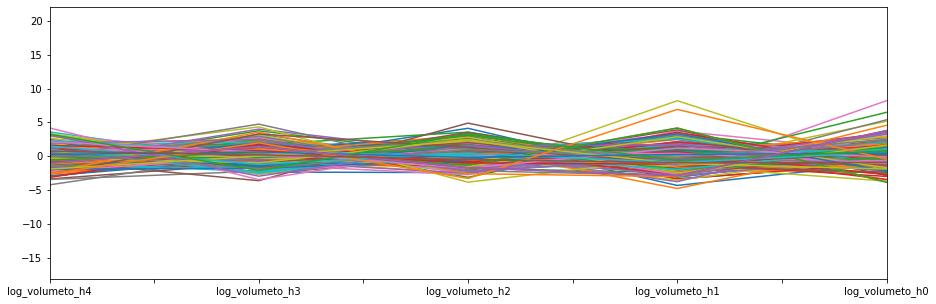

In [64]:
fig = plt.figure(figsize=(15,5))
plt.ylim(log_x_min,log_x_max)
for idx, row in t.iterrows():
    t.loc[idx].T[::-1][-5:].plot()
plt.show()

In [17]:
t = d[(d.currency != d.coin_name) & (d.exchange=="Binance")].filter(regex=log_x).sample(300)
# log_x_min = min(t.filter(regex=log_x).min())
# log_x_max = max(t.filter(regex=log_x).max())
print("Range for log_close_min: (",log_x_min,log_x_max,")")

Range for log_close_min: ( -18.148478242348972 22.047152737937683 )


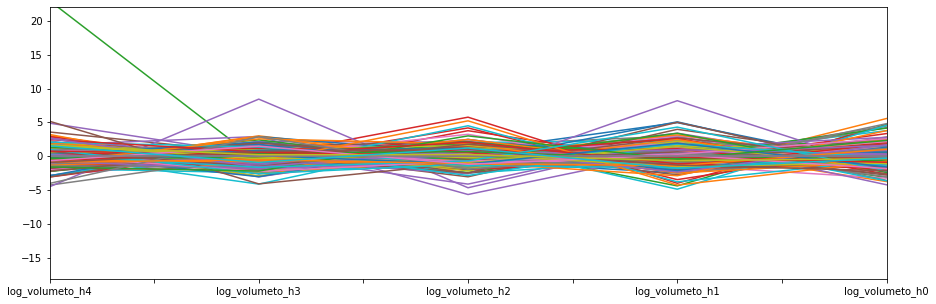

In [18]:
fig = plt.figure(figsize=(15,5))
plt.ylim(log_x_min,log_x_max)
for idx, row in t.iterrows():
    t.loc[idx].T[::-1][-5:].plot()
plt.show()

## Using Sum features
...Use statistical test to take a look at the positive and negative samples

In [19]:
exchange = "Binance"

In [20]:
def getStat(df, sum_var,exchange):
    d = df.copy()
    t1 = d.loc[(d.pumped_yn == 1) & (d.exchange==exchange),sum_var]
    t2 = d.loc[(d.pumped_yn != 1) & (d.exchange==exchange),sum_var]
    res = pd.DataFrame([t1.describe(),t2.describe()]).T
    res.columns = ["Pumped_"+sum_var+"_"+exchange,"Non_pumped_"+sum_var+"_"+exchange]
    return res

In [21]:
getStat(d,"log_volumefrom_h0",exchange)

,Pumped_log_volumefrom_h0_Binance,Non_pumped_log_volumefrom_h0_Binance
count,246.000000,27060.000000
mean,0.061928,0.004945
std,1.626917,1.833447
min,-3.815930,-34.547723
25%,-0.916998,-0.759063
50%,0.000000,0.000000
75%,0.779364,0.686030
max,7.907688,36.605443


In [25]:
getStat(d,"log_volumefrom_h1",exchange)

,Pumped_log_volumefrom_h1_Binance,Non_pumped_log_volumefrom_h1_Binance
count,246.000000,27060.000000
mean,-0.037313,0.047148
std,1.728717,1.655221
min,-4.838327,-32.599630
25%,-1.041277,-0.714065
50%,-0.119103,0.000000
75%,0.648518,0.744082
max,7.907688,36.605443


In [23]:
getStat(d,"log_3h_volumeto",exchange)

,Pumped_log_3h_volumeto_Binance,Non_pumped_log_3h_volumeto_Binance
count,246.000000,27060.000000
mean,0.055134,0.084243
std,1.705194,1.684238
min,-5.613879,-22.708122
25%,-0.924548,-0.753418
50%,0.000000,0.000000
75%,1.092846,0.915222
max,5.604897,23.947129


### VERIFY DATA

In [26]:
pd.DataFrame(d.columns).to_csv("Log_processed_data/log_columns.csv")

# PART III. PROCESS HOURLY SOCIAL DATA

In [72]:
s = pd.read_pickle("social_data_training_h.pkl")
print(s.shape)
s.head(3)

(80940, 1626)


,channelLink,channelTitle,currency,exchange,timestamp,signalTime,pumptime_edited,coin_name,coin_id,code_repo_stars_h0,code_repo_stars_h1,code_repo_stars_h2,code_repo_stars_h3,code_repo_stars_h4,code_repo_stars_h5,code_repo_stars_h6,code_repo_stars_h7,code_repo_stars_h8,code_repo_stars_h9,code_repo_stars_h10,code_repo_stars_h11,code_repo_stars_h12,code_repo_stars_h13,code_repo_stars_h14,code_repo_stars_h15,code_repo_stars_h16,code_repo_stars_h17,code_repo_stars_h18,code_repo_stars_h19,code_repo_stars_h20,code_repo_stars_h21,code_repo_stars_h22,code_repo_stars_h23,code_repo_stars_h24,code_repo_stars_h25,code_repo_stars_h26,code_repo_stars_h27,code_repo_stars_h28,code_repo_stars_h29,code_repo_stars_h30,code_repo_stars_h31,code_repo_stars_h32,code_repo_stars_h33,code_repo_stars_h34,code_repo_stars_h35,code_repo_stars_h36,code_repo_stars_h37,code_repo_stars_h38,code_repo_stars_h39,code_repo_stars_h40,code_repo_stars_h41,code_repo_stars_h42,code_repo_stars_h43,code_repo_stars_h44,code_repo_stars_h45,code_repo_stars_h46,code_repo_stars_h47,code_repo_stars_h48,code_repo_forks_h0,code_repo_forks_h1,code_repo_forks_h2,code_repo_forks_h3,code_repo_forks_h4,code_repo_forks_h5,code_repo_forks_h6,code_repo_forks_h7,code_repo_forks_h8,code_repo_forks_h9,code_repo_forks_h10,code_repo_forks_h11,code_repo_forks_h12,code_repo_forks_h13,code_repo_forks_h14,code_repo_forks_h15,code_repo_forks_h16,code_repo_forks_h17,code_repo_forks_h18,code_repo_forks_h19,code_repo_forks_h20,code_repo_forks_h21,code_repo_forks_h22,code_repo_forks_h23,code_repo_forks_h24,code_repo_forks_h25,code_repo_forks_h26,code_repo_forks_h27,code_repo_forks_h28,code_repo_forks_h29,code_repo_forks_h30,code_repo_forks_h31,code_repo_forks_h32,code_repo_forks_h33,code_repo_forks_h34,code_repo_forks_h35,code_repo_forks_h36,code_repo_forks_h37,code_repo_forks_h38,code_repo_forks_h39,code_repo_forks_h40,code_repo_forks_h41,...,forum_page_views_h47,forum_page_views_h48,influence_page_views_h0,influence_page_views_h1,influence_page_views_h2,influence_page_views_h3,influence_page_views_h4,influence_page_views_h5,influence_page_views_h6,influence_page_views_h7,influence_page_views_h8,influence_page_views_h9,influence_page_views_h10,influence_page_views_h11,influence_page_views_h12,influence_page_views_h13,influence_page_views_h14,influence_page_views_h15,influence_page_views_h16,influence_page_views_h17,influence_page_views_h18,influence_page_views_h19,influence_page_views_h20,influence_page_views_h21,influence_page_views_h22,influence_page_views_h23,influence_page_views_h24,influence_page_views_h25,influence_page_views_h26,influence_page_views_h27,influence_page_views_h28,influence_page_views_h29,influence_page_views_h30,influence_page_views_h31,influence_page_views_h32,influence_page_views_h33,influence_page_views_h34,influence_page_views_h35,influence_page_views_h36,influence_page_views_h37,influence_page_views_h38,influence_page_views_h39,influence_page_views_h40,influence_page_views_h41,influence_page_views_h42,influence_page_views_h43,influence_page_views_h44,influence_page_views_h45,influence_page_views_h46,influence_page_views_h47,influence_page_views_h48,total_page_views_h0,total_page_views_h1,total_page_views_h2,total_page_views_h3,total_page_views_h4,total_page_views_h5,total_page_views_h6,total_page_views_h7,total_page_views_h8,total_page_views_h9,total_page_views_h10,total_page_views_h11,total_page_views_h12,total_page_views_h13,total_page_views_h14,total_page_views_h15,total_page_views_h16,total_page_views_h17,total_page_views_h18,total_page_views_h19,total_page_views_h20,total_page_views_h21,total_page_views_h22,total_page_views_h23,total_page_views_h24,total_page_views_h25,total_page_views_h26,total_page_views_h27,total_page_views_h28,total_page_views_h29,total_page_views_h30,total_page_views_h31,total_page_views_h32,total_page_views_h33,total_page_views_h34,total_page_views_h35,total_page_views_h36,total_page_views_h37,total_page_views_h38,total_page_views_h39,total_page

In [73]:
social_ls = pd.read_pickle("social_features_h.pkl")
social_ls = np.unique(["_".join(x.split('_')[:-1]) for x in social_ls ])
print(social_ls)

['analysis_page_views' 'charts_page_views' 'code_repo_closed_issues'
 'code_repo_closed_pull_issues' 'code_repo_contributors' 'code_repo_forks'
 'code_repo_open_issues' 'code_repo_open_pull_issues' 'code_repo_stars'
 'code_repo_subscribers' 'comments' 'fb_likes' 'fb_talking_about'
 'followers' 'forum_page_views' 'influence_page_views'
 'markets_page_views' 'overview_page_views' 'points' 'posts'
 'reddit_active_users' 'reddit_comments_per_day'
 'reddit_comments_per_hour' 'reddit_posts_per_day' 'reddit_posts_per_hour'
 'reddit_subscribers' 'total_page_views' 'trades_page_views'
 'twitter_favourites' 'twitter_followers' 'twitter_following'
 'twitter_lists' 'twitter_statuses']


In [75]:
col_dict = pd.read_pickle("col_dict_h.pkl")
col_dict.keys()

dict_keys(['code', 'twitter', 'reddit', 'fb', 'market', 'core'])

In [80]:
base_feats = ['channelLink','channelTitle','currency','exchange','coin_name','timestamp']

In [76]:
#Market data and some others is cumulative so we want to identify them to not take the sum
exclude_ls = ['code_repo_forks'
,'fb_likes'
,'comments'
,'post'
,'followers' 
,'points'
,'overview_page_views'
,'analysis_page_views'
,'markets_page_views'
,'charts_page_views'
,'trades_page_views'
,'forum_page_views'
,'influence_page_views'
,'total_page_views']

Create the __LOG__ and __SUM__ features for EACH of these

## LOG

In [77]:
num_hours = 48

for f in social_ls:
    for h in range(num_hours+1):
        if h < num_hours: 
            s["log_"+f+"_h" +str(h)] = np.log(s[f+"_h" + str(h)] + 1) - np.log(s[f+"_h" + str(h+1)] +1 )

## SUM

In [79]:
#Reference point at h1 since we can't use data at 0 zero.
#Also add 1 to prevent undefined log
log_ls = []
sum_ls = []
for f in social_ls:
    for h in [1,3,6,9,12,24,36]:
        #Log difference first
        log_var = "log_"+str(h)+"h_"+f
        log_ls.append(log_var)
        s[log_var] = np.log(s[f+"_h1"] + 1) - np.log(s[f+"_h"+str(h+1)]+1)
#         print("log_"+str(h)+"h_"+f)
        #Sum data
        if f not in exclude_ls:
            sumvar = [f+"_h"+str(h) for h in range(1,h+1)]
    #         print(sumvar,"\n")
            sum_name = "sum_"+str(h)+"h_"+f
            sum_ls.append(sum_name)
            s[sum_name] = s[sumvar].sum(axis=1) #Sum by row

In [64]:
# log_ls
print(len(log_ls))

198


In [53]:
print(sum_ls)

['sum_3h_code_repo_closed_issues',
 'sum_6h_code_repo_closed_issues',
 'sum_9h_code_repo_closed_issues',
 'sum_12h_code_repo_closed_issues',
 'sum_24h_code_repo_closed_issues',
 'sum_36h_code_repo_closed_issues',
 'sum_3h_code_repo_closed_pull_issues',
 'sum_6h_code_repo_closed_pull_issues',
 'sum_9h_code_repo_closed_pull_issues',
 'sum_12h_code_repo_closed_pull_issues',
 'sum_24h_code_repo_closed_pull_issues',
 'sum_36h_code_repo_closed_pull_issues',
 'sum_3h_code_repo_contributors',
 'sum_6h_code_repo_contributors',
 'sum_9h_code_repo_contributors',
 'sum_12h_code_repo_contributors',
 'sum_24h_code_repo_contributors',
 'sum_36h_code_repo_contributors',
 'sum_3h_code_repo_open_issues',
 'sum_6h_code_repo_open_issues',
 'sum_9h_code_repo_open_issues',
 'sum_12h_code_repo_open_issues',
 'sum_24h_code_repo_open_issues',
 'sum_36h_code_repo_open_issues',
 'sum_3h_code_repo_open_pull_issues',
 'sum_6h_code_repo_open_pull_issues',
 'sum_9h_code_repo_open_pull_issues',
 'sum_12h_code_repo_op

In [66]:
[set(social_ls) - set(exclude_ls)]

[{'code_repo_closed_issues',
  'code_repo_closed_pull_issues',
  'code_repo_contributors',
  'code_repo_open_issues',
  'code_repo_open_pull_issues',
  'code_repo_stars',
  'code_repo_subscribers',
  'fb_talking_about',
  'posts',
  'reddit_active_users',
  'reddit_comments_per_day',
  'reddit_comments_per_hour',
  'reddit_posts_per_day',
  'reddit_posts_per_hour',
  'reddit_subscribers',
  'twitter_favourites',
  'twitter_followers',
  'twitter_following',
  'twitter_lists',
  'twitter_statuses'}]

In [99]:
pd.to_pickle(s[base_feats+log_ls + sum_ls], "Log_processed_data/social_data_training_h_log.pkl")

## VERIFY

In [19]:
s.head(3)

,channelLink,channelTitle,currency,exchange,timestamp,signalTime,pumptime_edited,coin_name,coin_id,code_repo_stars_h0,code_repo_stars_h1,code_repo_stars_h2,code_repo_stars_h3,code_repo_stars_h4,code_repo_stars_h5,code_repo_stars_h6,code_repo_stars_h7,code_repo_stars_h8,code_repo_stars_h9,code_repo_stars_h10,code_repo_stars_h11,code_repo_stars_h12,code_repo_stars_h13,code_repo_stars_h14,code_repo_stars_h15,code_repo_stars_h16,code_repo_stars_h17,code_repo_stars_h18,code_repo_stars_h19,code_repo_stars_h20,code_repo_stars_h21,code_repo_stars_h22,code_repo_stars_h23,code_repo_stars_h24,code_repo_stars_h25,code_repo_stars_h26,code_repo_stars_h27,code_repo_stars_h28,code_repo_stars_h29,code_repo_stars_h30,code_repo_stars_h31,code_repo_stars_h32,code_repo_stars_h33,code_repo_stars_h34,code_repo_stars_h35,code_repo_stars_h36,code_repo_stars_h37,code_repo_stars_h38,code_repo_stars_h39,code_repo_stars_h40,code_repo_stars_h41,code_repo_stars_h42,code_repo_stars_h43,code_repo_stars_h44,code_repo_stars_h45,code_repo_stars_h46,code_repo_stars_h47,code_repo_stars_h48,code_repo_forks_h0,code_repo_forks_h1,code_repo_forks_h2,code_repo_forks_h3,code_repo_forks_h4,code_repo_forks_h5,code_repo_forks_h6,code_repo_forks_h7,code_repo_forks_h8,code_repo_forks_h9,code_repo_forks_h10,code_repo_forks_h11,code_repo_forks_h12,code_repo_forks_h13,code_repo_forks_h14,code_repo_forks_h15,code_repo_forks_h16,code_repo_forks_h17,code_repo_forks_h18,code_repo_forks_h19,code_repo_forks_h20,code_repo_forks_h21,code_repo_forks_h22,code_repo_forks_h23,code_repo_forks_h24,code_repo_forks_h25,code_repo_forks_h26,code_repo_forks_h27,code_repo_forks_h28,code_repo_forks_h29,code_repo_forks_h30,code_repo_forks_h31,code_repo_forks_h32,code_repo_forks_h33,code_repo_forks_h34,code_repo_forks_h35,code_repo_forks_h36,code_repo_forks_h37,code_repo_forks_h38,code_repo_forks_h39,code_repo_forks_h40,code_repo_forks_h41,...,log_24h_reddit_posts_per_hour,sum_24h_reddit_posts_per_hour,log_36h_reddit_posts_per_hour,sum_36h_reddit_posts_per_hour,log_3h_reddit_subscribers,sum_3h_reddit_subscribers,log_6h_reddit_subscribers,sum_6h_reddit_subscribers,log_9h_reddit_subscribers,sum_9h_reddit_subscribers,log_12h_reddit_subscribers,sum_12h_reddit_subscribers,log_24h_reddit_subscribers,sum_24h_reddit_subscribers,log_36h_reddit_subscribers,sum_36h_reddit_subscribers,log_3h_total_page_views,sum_3h_total_page_views,log_6h_total_page_views,sum_6h_total_page_views,log_9h_total_page_views,sum_9h_total_page_views,log_12h_total_page_views,sum_12h_total_page_views,log_24h_total_page_views,sum_24h_total_page_views,log_36h_total_page_views,sum_36h_total_page_views,log_3h_trades_page_views,sum_3h_trades_page_views,log_6h_trades_page_views,sum_6h_trades_page_views,log_9h_trades_page_views,sum_9h_trades_page_views,log_12h_trades_page_views,sum_12h_trades_page_views,log_24h_trades_page_views,sum_24h_trades_page_views,log_36h_trades_page_views,sum_36h_trades_page_views,log_3h_twitter_favourites,sum_3h_twitter_favourites,log_6h_twitter_favourites,sum_6h_twitter_favourites,log_9h_twitter_favourites,sum_9h_twitter_favourites,log_12h_twitter_favourites,sum_12h_twitter_favourites,log_24h_twitter_favourites,sum_24h_twitter_favourites,log_36h_twitter_favourites,sum_36h_twitter_favourites,log_3h_twitter_followers,sum_3h_twitter_followers,log_6h_twitter_followers,sum_6h_twitter_followers,log_9h_twitter_followers,sum_9h_twitter_followers,log_12h_twitter_followers,sum_12h_twitter_followers,log_24h_twitter_followers,sum_24h_twitter_followers,log_36h_twitter_followers,sum_36h_twitter_followers,log_3h_twitter_following,sum_3h_twitter_following,log_6h_twitter_following,sum_6h_twitter_following,log_9h_twitter_following,sum_9h_twitter_following,log_12h_twitter_following,sum_12h_twitter_following,log_24h_twitter_following,sum_24h_twitter_following,log_36h_twitter_following,sum_36h_twitter_following,log_3h_twitter_lists,sum_3h_twitter_lists,log_6h_twitter_lists,sum_6h_twitter_lists,log_9h_twitter_lists,sum_9h_twitter_lists,log

In [71]:
# s.filter(regex="^[z]*code_repo_for")

In [68]:
# s[['timestamp','currency','coin_name','total_page_views_h0', 'total_page_views_h1', 'total_page_views_h2',
#        'total_page_views_h3', 'total_page_views_h4', 'total_page_views_h5',
#        'total_page_views_h6','sum_6h_total_page_views']]

In [69]:
s.shape

(80940, 3528)

In [70]:
len(log_ls + sum_ls)

318